In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("..")

from utils.funciones_toolbox_ml_final import *
from utils.modulos import *

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, recall_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.metrics import Recall



## Problema de negocio

El síndrome metabólico es un conjunto de condiciones médicas que aumentan el riesgo de enfermedades cardiovasculares, diabetes tipo 2 y otros problemas de salud. Estas condiciones incluyen hipertensión arterial, niveles altos de azúcar en la sangre, exceso de grasa abdominal y niveles anormales de colesterol o triglicéridos en la sangre, por lo que se nos pide:

**Identificar a las personas en riesgo para crear posteriormente programas de salud e intervenciones preventivas y personalizadas para éstos pacientes**

## Objetivo técnico

- Crear un modelo supervisado de clasificación

## Métricas

 - El recall de la clase 1 sería la métrica adecuada para evaluar qué tan bien el modelo identifica a todos los pacientes que tienen el síndrome metabólico, donde la clase positiva representa a los pacientes enfermos (clase 1). Al establecer el recall como la métrica objetivo, se prioriza la capacidad del modelo para detectar a todos los pacientes con síndrome metabólico. Esto asegura que el modelo esté optimizado para capturar la mayor cantidad posible de casos positivos, lo que es crucial para identificar a las personas en riesgo y proporcionarles la atención médica adecuada.

## Obtención de los datos

In [2]:
df = pd.read_csv("../data/MetabolicSyndrome.csv")
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 281.5+ KB


In [4]:
describe_df(df)

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
Tipo,int64,int64,object,object,float64,object,float64,float64,int64,float64,float64,int64,int64,int64,int64
Porcentaje_Nulos,0.0,0.0,0.0,8.663057,4.87297,0.0,3.540192,1.082882,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Valores_Unicos,2401,61,2,5,14,6,635,322,3,1383,88,187,93,345,2
Porcentaje_Cardinalidad,100.0,2.540608,0.083299,0.208247,0.58309,0.249896,26.447314,13.411079,0.124948,57.601,3.66514,7.788421,3.873386,14.369013,0.083299


In [5]:
tabla_descriptiva = tipifica_variables(df,10,30)
tabla_descriptiva

,nombre_variable,tipo_sugerido
0,seqn,Numerica Continua
1,Age,Numerica Discreta
2,Sex,Binaria
3,Marital,Categorica
4,Income,Numerica Discreta
5,Race,Categorica
6,WaistCirc,Numerica Discreta
7,BMI,Numerica Discreta
8,Albuminuria,Categorica
9,UrAlbCr,Numerica Continua


In [6]:
descripcion = {"Descripcion":["Índice único", "Edad", "Género", 
                              "Estado civil","Ingresos", "Raza",
                              "Circunferencia Abdominal", "Índice de Masa Corporal",
                              "Medida de Albumina en orina", "Relación Albumina-Creatitina en orina",
                              "Ácido Úrico", "Azúcar en sangre", 
                              "Niveles de colesterol de lipoproteínas de alta densidad('colesterol bueno')",
                              "Triglicéridos", "Indica la presencia (1) o ausencia (0) de síndrome metabólico"
                              ]}
df_descripcion = pd.DataFrame(descripcion)

tabla_descriptiva = pd.concat([tabla_descriptiva, df_descripcion], axis=1)

In [7]:
tabla_descriptiva
tabla_descriptiva

,nombre_variable,tipo_sugerido,Descripcion
0,seqn,Numerica Continua,Índice único
1,Age,Numerica Discreta,Edad
2,Sex,Binaria,Género
3,Marital,Categorica,Estado civil
4,Income,Numerica Discreta,Ingresos
5,Race,Categorica,Raza
6,WaistCirc,Numerica Discreta,Circunferencia Abdominal
7,BMI,Numerica Discreta,Índice de Masa Corporal
8,Albuminuria,Categorica,Medida de Albumina en orina
9,UrAlbCr,Numerica Continua,Relación Albumina-Creatitina en orina


- Voy a eliminar las columnas "seqn" que no me aportan nada a la hora de realizar el modelo, "seqn" porque es un índice de los pacientes y tiene una cardinalidad del 100%, y elimino "UrAlbCr" porque aporta la misma información que Albuminuria

In [8]:
df.drop(columns=["seqn", "UrAlbCr"], inplace= True)

In [9]:
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

- Hay 4 columnas con valores nulos, de las cuales "Marital" es la única categórica.

In [10]:
df.describe()

,Age,Income,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,4005.253940,98.307254,28.702189,0.154102,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,2954.032186,16.252634,6.662242,0.422780,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,300.000000,56.200000,13.400000,0.000000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,1600.000000,86.675000,24.000000,0.000000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,2500.000000,97.000000,27.700000,0.000000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,6200.000000,107.625000,32.100000,0.000000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,9000.000000,176.000000,68.700000,2.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


In [11]:
# Verificamos que no hayan duplicados
print(df.duplicated().sum())

0


## Separar en Train y Test

In [12]:
train_set, test_set = train_test_split(df, test_size=0.2, stratify= df["MetabolicSyndrome"],random_state=73)

In [13]:
train_set["MetabolicSyndrome"].value_counts()

MetabolicSyndrome
0    1263
1     657
Name: count, dtype: int64

In [14]:
test_set["MetabolicSyndrome"].value_counts()

MetabolicSyndrome
0    316
1    165
Name: count, dtype: int64

## Mini EDA

#### Definimos el target

In [15]:
target = "MetabolicSyndrome"

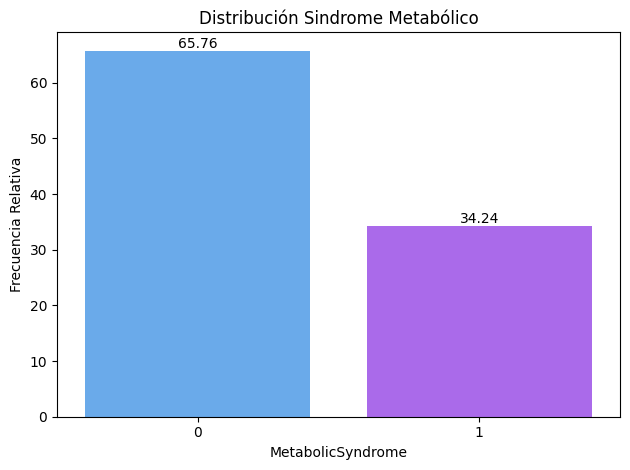

In [16]:
barplot_categorica(df, target)

- El target está desbalanceado, hay mayor concentración de pacientes hacía la clase 0 es decir los pacientes sanos, tendré que tener éste factor en cuenta a la hora de realizar el modelo porque lo que nos interesa conseguir es la mayor precisión en el grupo 1.

In [17]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1920 entries, 651 to 1230
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1920 non-null   int64  
 1   Sex                1920 non-null   object 
 2   Marital            1746 non-null   object 
 3   Income             1821 non-null   float64
 4   Race               1920 non-null   object 
 5   WaistCirc          1858 non-null   float64
 6   BMI                1902 non-null   float64
 7   Albuminuria        1920 non-null   int64  
 8   UricAcid           1920 non-null   float64
 9   BloodGlucose       1920 non-null   int64  
 10  HDL                1920 non-null   int64  
 11  Triglycerides      1920 non-null   int64  
 12  MetabolicSyndrome  1920 non-null   int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 210.0+ KB


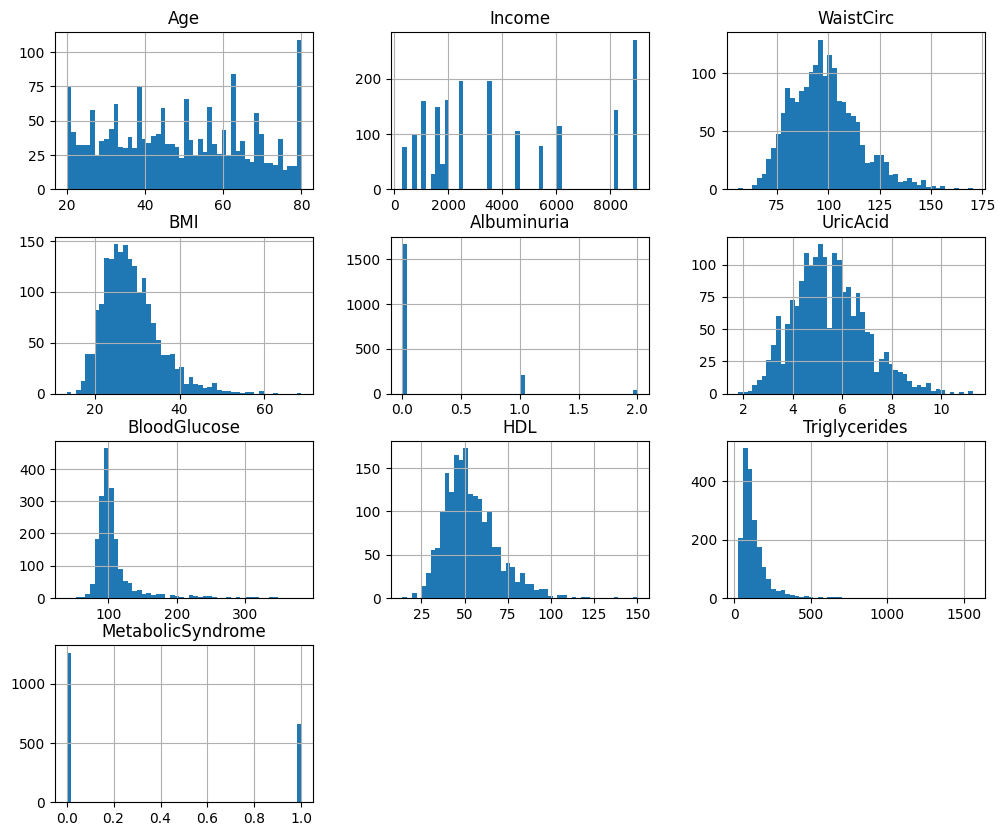

In [18]:
train_set.hist(bins=50, figsize=(12, 10))
plt.show()

- Voy a empezar por imputar nulos a las columnas:

    - Marital: Moda
    - Income: Media
    - WaistCirc: Media
    - BMI:Media                   

In [19]:
waist_circ_media = train_set["WaistCirc"].mean()
bmi_media = train_set["BMI"].mean()
income_media = train_set["Income"].mean()
marital_moda = train_set["Marital"].mode()[0]
train_set["WaistCirc"].fillna(waist_circ_media, inplace=True)
train_set["BMI"].fillna(waist_circ_media, inplace=True)
train_set["Income"].fillna(income_media, inplace = True)
train_set["Marital"].fillna(marital_moda, inplace = True)

- Hago lo mismo al test

In [20]:
test_set["WaistCirc"].fillna(waist_circ_media, inplace=True)
test_set["BMI"].fillna(waist_circ_media, inplace=True)
test_set["Income"].fillna(income_media, inplace = True)
test_set["Marital"].fillna(marital_moda, inplace = True)

- Como ya he realizado el EDA anteriormente, sé que hay features que tiene muchos outliers por lo que voy a categorizarlas para poder tratar esos valores atípicos.

In [21]:
#Categorizar BMI
bins = [-np.inf, 18.5, 24.9, 29.9, np.inf]
labels = ['Bajo peso', 'Normal', 'Sobrepeso', 'Obesidad']
train_set['categoria_bmi'] = pd.cut(train_set["BMI"], bins=bins, labels=labels)
print(train_set['categoria_bmi'].value_counts())

categoria_bmi
Obesidad     700
Sobrepeso    610
Normal       575
Bajo peso     35
Name: count, dtype: int64


In [22]:
#Categorizar BloodGlucose
bins = [-np.inf, 99, 126, np.inf]
labels = ['Normal', 'Prediabetes', 'Diabetes']
train_set['categoria_bloodglucose'] = pd.cut(train_set["BloodGlucose"], bins=bins, labels=labels)
print(train_set['categoria_bloodglucose'].value_counts())

categoria_bloodglucose
Normal         961
Prediabetes    720
Diabetes       239
Name: count, dtype: int64


In [23]:
#Categorizar trigliceridos
def categorizar_trigliceridos(edad, trigliceridos):

    if edad >= 10 and edad <= 19:  # Niños y adolescentes
        if trigliceridos < 90:
            return 'Nivel normal'
        elif 90 <= trigliceridos < 150:
            return 'Niveles ligeramente altos'
        elif 150 <= trigliceridos:
            return 'Niveles altos'
    else:  # Adultos
        if trigliceridos < 150:
            return 'Nivel normal'
        elif 150 <= trigliceridos < 200:
            return 'Niveles ligeramente altos'
        elif 200 <= trigliceridos < 500:
            return 'Niveles altos'
        else:
            return 'Niveles muy altos'
        
train_set['categoria_trigliceridos'] = train_set.apply(lambda x: categorizar_trigliceridos(x["Age"], x["Triglycerides"]), axis=1)

In [24]:
print(train_set['categoria_trigliceridos'].value_counts())


categoria_trigliceridos
Nivel normal                 1441
Niveles ligeramente altos     242
Niveles altos                 219
Niveles muy altos              18
Name: count, dtype: int64


In [25]:
def categorizar_hdl(genero, hdl):
    if genero == 'Male':
        if hdl < 40:
            return 'Valor_Bajo'
        else:
            return 'Normal'
    elif genero == 'Female':
        if hdl < 50:
            return 'Valor_Bajo'
        elif hdl >= 50:
            return 'Normal'


In [26]:
train_set['categoria_hdl'] = train_set.apply(lambda x: categorizar_hdl(x["Sex"], x["HDL"]), axis=1)


In [27]:
print(train_set['categoria_hdl'].value_counts())


categoria_hdl
Normal        1403
Valor_Bajo     517
Name: count, dtype: int64


In [28]:
def categorizar_circunferencia_abdominal(genero, circunferencia):
    if genero == 'Female':
        if circunferencia > 88:
            return 'Riesgo Elevado'
        else:
            return 'Normal'
    elif genero == 'Male':
        if circunferencia > 102:
            return 'Riesgo Elevado'
        else:
            return 'Normal'


In [29]:
train_set['categoria_circunferencia'] = train_set.apply(lambda x: categorizar_circunferencia_abdominal(x["Sex"], x["WaistCirc"]), axis=1)


In [30]:
print(train_set['categoria_circunferencia'].value_counts())


categoria_circunferencia
Riesgo Elevado    1028
Normal             892
Name: count, dtype: int64


In [31]:
train_set

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,categoria_bmi,categoria_bloodglucose,categoria_trigliceridos,categoria_hdl,categoria_circunferencia
651,38,Male,Single,800.0,Black,142.0,48.0,1,7.1,116,59,91,1,Obesidad,Prediabetes,Nivel normal,Normal,Riesgo Elevado
1111,30,Male,Married,9000.0,Asian,95.1,28.1,0,5.5,103,41,428,1,Sobrepeso,Prediabetes,Niveles altos,Normal,Normal
392,41,Male,Married,6200.0,Black,92.1,27.0,0,6.4,94,37,26,0,Sobrepeso,Normal,Nivel normal,Valor_Bajo,Normal
1877,54,Male,Married,3500.0,Hispanic,102.7,29.6,0,6.4,104,37,291,1,Sobrepeso,Prediabetes,Niveles altos,Valor_Bajo,Riesgo Elevado
962,76,Male,Married,2000.0,Asian,84.7,21.2,1,9.6,138,56,157,1,Normal,Diabetes,Niveles ligeramente altos,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,21,Female,Married,3500.0,Hispanic,82.7,22.0,0,4.3,89,48,65,0,Normal,Normal,Nivel normal,Valor_Bajo,Normal
2197,26,Female,Single,2000.0,Asian,138.2,44.5,0,7.3,107,47,112,1,Obesidad,Prediabetes,Nivel normal,Valor_Bajo,Riesgo Elevado
1242,51,Female,Separated,1700.0,MexAmerican,80.4,21.9,0,3.7,91,59,53,0,Normal,Normal,Nivel normal,Normal,Normal
1083,47,Male,Divorced,2500.0,White,106.6,28.8,0,6.1,93,36,154,1,Sobrepeso,Normal,Niveles ligeramente altos,Valor_Bajo,Riesgo Elevado


In [32]:
train_set.drop(columns=["WaistCirc","BMI","BloodGlucose","HDL","Triglycerides"], inplace=True)

In [33]:
train_set

,Age,Sex,Marital,Income,Race,Albuminuria,UricAcid,MetabolicSyndrome,categoria_bmi,categoria_bloodglucose,categoria_trigliceridos,categoria_hdl,categoria_circunferencia
651,38,Male,Single,800.0,Black,1,7.1,1,Obesidad,Prediabetes,Nivel normal,Normal,Riesgo Elevado
1111,30,Male,Married,9000.0,Asian,0,5.5,1,Sobrepeso,Prediabetes,Niveles altos,Normal,Normal
392,41,Male,Married,6200.0,Black,0,6.4,0,Sobrepeso,Normal,Nivel normal,Valor_Bajo,Normal
1877,54,Male,Married,3500.0,Hispanic,0,6.4,1,Sobrepeso,Prediabetes,Niveles altos,Valor_Bajo,Riesgo Elevado
962,76,Male,Married,2000.0,Asian,1,9.6,1,Normal,Diabetes,Niveles ligeramente altos,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,21,Female,Married,3500.0,Hispanic,0,4.3,0,Normal,Normal,Nivel normal,Valor_Bajo,Normal
2197,26,Female,Single,2000.0,Asian,0,7.3,1,Obesidad,Prediabetes,Nivel normal,Valor_Bajo,Riesgo Elevado
1242,51,Female,Separated,1700.0,MexAmerican,0,3.7,0,Normal,Normal,Nivel normal,Normal,Normal
1083,47,Male,Divorced,2500.0,White,0,6.1,1,Sobrepeso,Normal,Niveles ligeramente altos,Valor_Bajo,Riesgo Elevado


- Hago lo mismo con el test

In [34]:
#Categorizar BMI
bins = [-np.inf, 18.5, 24.9, 29.9, np.inf]
labels = ['Bajo peso', 'Normal', 'Sobrepeso', 'Obesidad']
test_set['categoria_bmi'] = pd.cut(test_set["BMI"], bins=bins, labels=labels)

In [35]:
#Categorizar BloodGlucose
bins = [-np.inf, 99, 126, np.inf]
labels = ['Normal', 'Prediabetes', 'Diabetes']
test_set['categoria_bloodglucose'] = pd.cut(test_set["BloodGlucose"], bins=bins, labels=labels)


In [36]:
#Categorizar Trigliceridos
test_set['categoria_trigliceridos'] = test_set.apply(lambda x: categorizar_trigliceridos(x["Age"], x["Triglycerides"]), axis=1)

In [37]:
#Categorizar HDL
test_set['categoria_hdl'] = test_set.apply(lambda x: categorizar_hdl(x["Sex"], x["HDL"]), axis=1)

In [38]:
#Categorizar Circunferencia abdominal
test_set['categoria_circunferencia'] = test_set.apply(lambda x: categorizar_circunferencia_abdominal(x["Sex"], x["WaistCirc"]), axis=1)

In [39]:
test_set.drop(columns=["WaistCirc","BMI","BloodGlucose","HDL","Triglycerides"], inplace=True)

In [40]:
test_set_copy = test_set.copy()

### Procesado de Features

#### Tratamiento de las features categóricas

In [41]:
train_set = pd.get_dummies(train_set, columns=["Sex", "Marital", "Race","categoria_bloodglucose","categoria_bmi","categoria_trigliceridos","categoria_hdl","categoria_circunferencia"], dtype = int)


In [42]:
train_set

,Age,Income,Albuminuria,UricAcid,MetabolicSyndrome,Sex_Female,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,...,categoria_bmi_Sobrepeso,categoria_bmi_Obesidad,categoria_trigliceridos_Nivel normal,categoria_trigliceridos_Niveles altos,categoria_trigliceridos_Niveles ligeramente altos,categoria_trigliceridos_Niveles muy altos,categoria_hdl_Normal,categoria_hdl_Valor_Bajo,categoria_circunferencia_Normal,categoria_circunferencia_Riesgo Elevado
651,38,800.0,1,7.1,1,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,1
1111,30,9000.0,0,5.5,1,0,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
392,41,6200.0,0,6.4,0,0,1,0,1,0,...,1,0,1,0,0,0,0,1,1,0
1877,54,3500.0,0,6.4,1,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,1
962,76,2000.0,1,9.6,1,0,1,0,1,0,...,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,21,3500.0,0,4.3,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
2197,26,2000.0,0,7.3,1,1,0,0,0,0,...,0,1,1,0,0,0,0,1,0,1
1242,51,1700.0,0,3.7,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
1083,47,2500.0,0,6.1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,1,0,1


In [43]:
test_set = pd.get_dummies(test_set, columns=["Sex", "Marital", "Race","categoria_bloodglucose","categoria_bmi","categoria_trigliceridos","categoria_hdl","categoria_circunferencia"], dtype = int)

#### Tratamiento de features numéricas

In [44]:
features_num = ['Age','Income','UricAcid','Albuminuria']

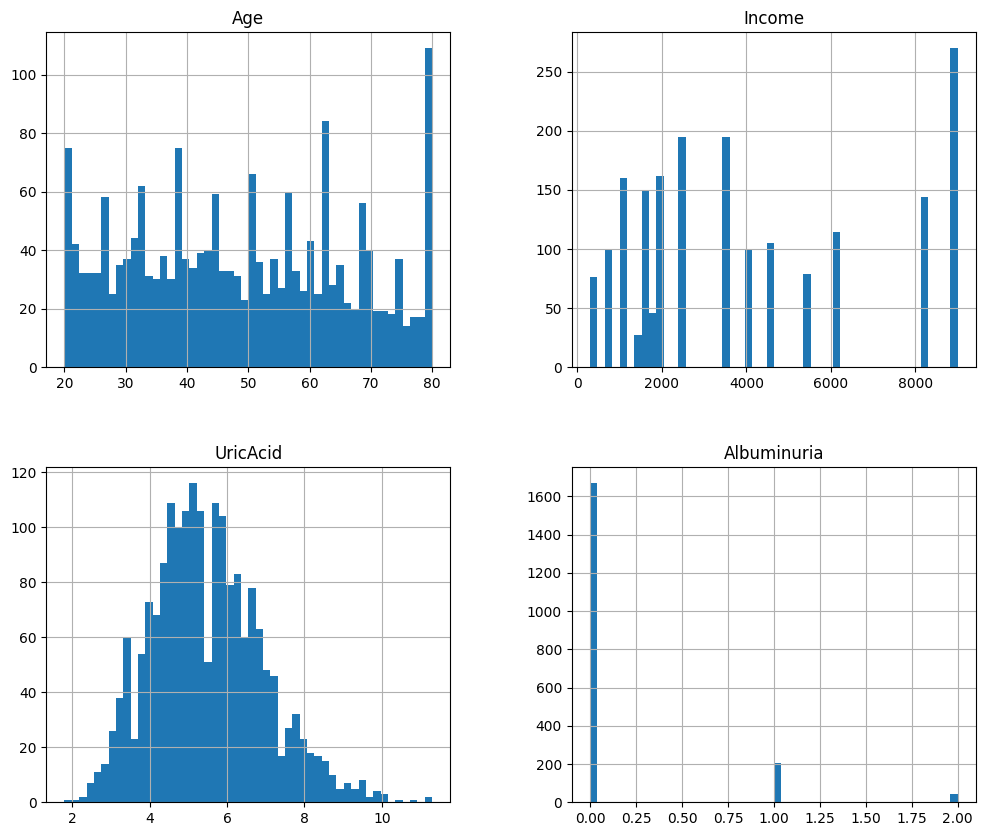

In [45]:
train_set[features_num].hist(bins=50, figsize=(12, 10))
plt.show()

In [46]:
train_set_pt = train_set.copy()
test_set_pt = test_set.copy()

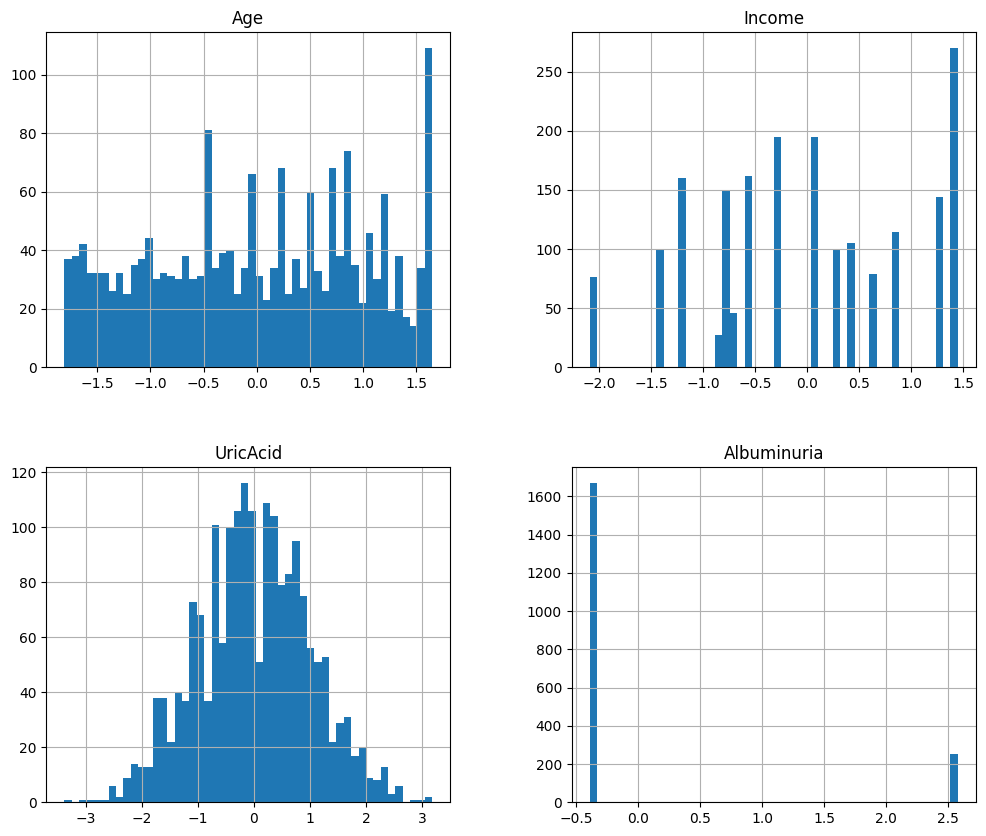

In [47]:
pt = PowerTransformer()
train_set_pt[features_num] = pt.fit_transform(train_set_pt[features_num])
test_set_pt = test_set.copy()
test_set_pt[features_num] = pt.transform(test_set_pt[features_num]) 
train_set_pt[features_num].hist(bins=50, figsize=(12, 10))
plt.show()

#### Separamos en X,y 

In [48]:
X_train_pt= train_set_pt.drop(columns=target)
y_train_pt = train_set_pt[target]
X_test_pt= test_set_pt.drop(columns=target)
y_test_pt = test_set_pt[target]

### Modelado

In [49]:
features = [col for col in train_set_pt.columns if col != target]
len(features)

32

In [50]:
factor_expansion = 3
num_units = len(features) * factor_expansion

In [51]:
model = keras.Sequential([
layers.Dense(256, activation='relu', input_shape=[len(features)]),
layers.Dense(128, activation='relu'),
layers.Dense(64, activation='relu'),
layers.Dense(32, activation='relu'),
layers.Dense(1, activation='sigmoid')
])



model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=[Recall()])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               8448      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51713 (202.00 KB)
Trainable params: 51713 (202.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
history = model.fit(
    X_train_pt,
    y_train_pt,
    batch_size=32, 
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10

48/48 [==============================] - 1s 8ms/step - loss: 0.3795 - recall: 0.6429 - val_loss: 0.2461 - val_recall: 0.9200
Epoch 2/10
48/48 [==============================] - 0s 3ms/step - loss: 0.2299 - recall: 0.8496 - val_loss: 0.2430 - val_recall: 0.9200
Epoch 3/10
48/48 [==============================] - 0s 3ms/step - loss: 0.1948 - recall: 0.8853 - val_loss: 0.2427 - val_recall: 0.8960
Epoch 4/10
48/48 [==============================] - 0s 3ms/step - loss: 0.1899 - recall: 0.8741 - val_loss: 0.2418 - val_recall: 0.8160
Epoch 5/10
48/48 [==============================] - 0s 5ms/step - loss: 0.1775 - recall: 0.8853 - val_loss: 0.2393 - val_recall: 0.8400
Epoch 6/10
48/48 [==============================] - 0s 3ms/step - loss: 0.1637 - recall: 0.8910 - val_loss: 0.2592 - val_recall: 0.6960
Epoch 7/10
48/48 [==============================] - 0s 3ms/step - loss: 0.1468 - recall: 0.9117 - val_loss: 0.2556 - val_recall: 0.8560
Epoch 8/10
48/48 [=============================

In [54]:
model.evaluate(X_test_pt,y_test_pt)

16/16 [==============================] - 0s 2ms/step - loss: 0.3793 - recall: 0.8000


[0.3792988955974579, 0.800000011920929]

In [55]:
y_pred = [round(prediction[0]) for prediction in model.predict(X_test_pt)]
y_pred[0:5]

16/16 [==============================] - 0s 2ms/step


[0, 1, 1, 0, 0]

In [56]:
print(classification_report(y_test_pt, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       316
           1       0.76      0.80      0.78       165

    accuracy                           0.85       481
   macro avg       0.83      0.84      0.83       481
weighted avg       0.85      0.85      0.85       481

